<a href="https://colab.research.google.com/github/Karthik-Ragunath/Deep_Learning_Notebooks/blob/master/Summarizer_Batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps

def make_batch():
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    # returns [np.array-dim(num_words_in_sentence, n_class)] # n_class represents one hot encoding length
    # outer list of dim 1
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    # returns [np.array-dim(num_words_in_sentence, one_hot_encoding_length)]
    # outer list is of dimension 1
    target_batch = [[word_dict[n] for n in sentences[2].split()]]
    print('output_batch:', output_batch)
    print('target_batch:', target_batch)
    # returns dimension - [[word_len]]
    # here too outer list of size 1

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)
    # creates tensor of size (1,num_token_sent_1,n_class), (1,num_token_sent_2,n_class), (1,num_token_sent_3) 

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        print("Hidden Layer Size:", n_hidden)
        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]

        # enc_outputs : [n_step (sequence_len), batch_size, num_directions(=1) * n_hidden], matrix F
        # enc_hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden) 

        trained_attn = []
        hidden = enc_hidden
        n_step = len(dec_inputs) # n_step - sequence_length
        model = torch.empty([n_step, 1, n_class]) # same torch.empty(n_step, 1, n_class) - gives tensor of shape (seq_len, 1, input_feature_size)

        # If there are multiple batches just make sure to add an outer for loop
        # to traverse through different batches and to maintain 3 dimensions, use unsqueeze(batch_dim)
        for i in range(n_step):  # each time step
            # dec_output : [n_step(=1), batch_size(=1), num_directions(=1) * n_hidden]
            # hidden : [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden) # unsqueezing is done to maintain input_shape - shape maintained = (1, batch_size, n_class)
            attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step] # to compute impact of rest of timestamps on one timestamp, 
                                                                                                         # thats why decoder output is 1 element (unsqueezed) and encoder output is in list 
            trained_attn.append(attn_weights.squeeze().data.numpy()) # (1,1,num_steps) gets squeezed into numpy array of size (num_steps) where num_steps = sequence_len or time_stamps

            # matrix-matrix product of matrices [1,1,n_step] x [1,n_step,n_hidden] = [1,1,n_hidden]
            context = attn_weights.bmm(enc_outputs.transpose(0, 1)) # performing batch matrix multiplication
            # (1,1,seq_len) * (seq_len, batch_size, n_hidden*n_directions(=1)).transpose(0,1) where n_class reders to features of input based on which one hot encoding is done
            # (1,1,seq_len) * (batch_size, seq_len, n_hidden*n_directions(=1)) - we are considering only one batch here, therefore,
            # (1,1,seq_len) * (1, seq_len, num_dirns(=1)*n_hidden) = (1, 1, num_dirns(=1)*n_hidden)
            dec_output = dec_output.squeeze(0)  # dec_output : [batch_size(=1), num_directions(=1) * n_hidden]
            # after squeezing [n_step(=1),batch_size(=1), num_directions(=1)*n_hidden] in 0th dimension - [batch_size(=1), num_directions(=1)*n_hidden]  
            context = context.squeeze(1)  # [1, num_directions(=1) * n_hidden]
            # after squeezing [1,1, num_dirns(=1)*n_hidden] in 0th dimension - [1,  num_dirns(=1)*n_hidden]
            model[i] = self.out(torch.cat((dec_output, context), 1))
            # torch.cat return (1, (num_directions(=1) * n_hidden) + (num_directions(=1) * n_hidden)) = (1, 2 * num_directions(=1) * n_hidden)
            # (1, 2 * num_directions(=1) * n_hidden) * (2*num_directions(=1)*n_hidden, n_class) # n_class represents input features used for one hot encoding
            # which will return (1, n_class)

        # make model shape [n_step, n_class]
        return model.transpose(0, 1).squeeze(0), trained_attn
        # model overall shape - [seq_len, 1, n_class]
        # [seq_len, 1, n_class].transpose(0, 1) returns shape - [1, seq_len, n_class]
        # [seq_len, 1, n_class] squeezing on dimension 0 returns (seq_len, n_class) # seq_len is same as n_step or number_of_timestamps


    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs) # n_step = seq_len
        attn_scores = torch.zeros(n_step)  # attn_scores : [n_step]
        # dec
        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1) # gets softmax output from list of size seq_len (time_stamps)
        # returns dimension of size (1,1,seq_len)


    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
        # attn = nn.Linear(n_hidden, n_hidden) - enc_output = (batch_size, n_hidden * num_dirns) - dec_output = (Batch_size, n_hidden * num_dirns)
        # (batch_size, n_hidden*num_dirns) * (n_hidden, n_hidden) = (batch_size, n_hidden)
        return torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value
        # .view(-1) unravels the last dimension which will result in 2 dimesnional tensor becoming 1 dimensional
        # .view(-1) will therefore return dimension - vector of dimension batch_size * n_hidden
        # dot product will be scalar

if __name__ == '__main__':
    n_step = 5 # number of cells(= number of Step)
    n_hidden = 128 # number of hidden units in one cell

    sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    number_dict = {i: w for i, w in enumerate(word_list)}

    # print(word_list, word_dict, number_dict)
    n_class = len(word_dict)  # vocab list

    # hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
    hidden = torch.zeros(1, 1, n_hidden)
    # print('n_class:', n_class)
    # print('*****************')
    # print('hidden:', hidden)
    # print('len hidden:', len(hidden[0][0]))

    model = Attention()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    input_batch, output_batch, target_batch = make_batch()
    # creates tensor of size (1,num_token_sent_1,n_class), (1,num_token_sent_2,n_class), (1,num_token_sent_3)

    # # Train
    for epoch in range(2000):
        optimizer.zero_grad()
        # clears gradients stored in .grad buffer from previous epoch
        output, _ = model(input_batch, hidden, output_batch)
        # invokes forward mehod and performs forward pass
        loss = criterion(output, target_batch.squeeze(0))
        # computing loss
        if (epoch + 1) % 400 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        # back-propagates the gradient error to previous layers
        optimizer.step()
        # updates the parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Hidden Layer Size: 128
output_batch: [array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]
target_batch: [[2, 10, 4, 1, 3]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0400 cost = 0.000446
Epoch: 0800 cost = 0.000144
Epoch: 1200 cost = 0.000071
Epoch: 1600 cost = 0.000042
Epoch: 2000 cost = 0.000027


In [ ]:
number_dict

{0: 'P',
 1: 'beer',
 2: 'i',
 3: 'E',
 4: 'a',
 5: 'ich',
 6: 'bier',
 7: 'mochte',
 8: 'S',
 9: 'ein',
 10: 'want'}

In [ ]:
    # # Test
    # test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]
    # test_batch = torch.FloatTensor(test_batch)
    # predict, trained_attn = model(input_batch, hidden, test_batch)
    # predict = predict.data.max(1, keepdim=True)[1]
    # print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

In [ ]:
with torch.no_grad():
    test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]
    # create one hot encoding
    test_batch = torch.FloatTensor(test_batch)
    # convert list of numpy arrays to tensor
    predict, trained_attn = model(input_batch, hidden, test_batch)
    predict = predict.data.max(1, keepdim=True)[1]
    print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


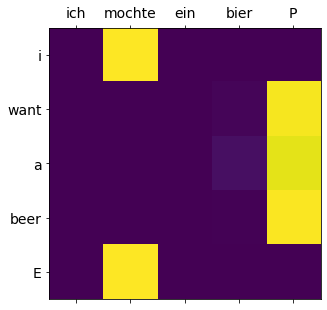

In [ ]:
    # Show Attention
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(trained_attn, cmap='viridis')
    ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
    ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

In [ ]:
import pandas as pd
english_french_df = pd.read_csv('/content/sample_data/English_French_translation_tab_delimited.csv', delimiter='\t', index_col=0)

In [ ]:
english_french_df

,en,fr
0,Changing Lives | Changing Society | How It Wor...,Il a transformé notre vie | Il a transformé la...
1,Site map,Plan du site
2,Feedback,Rétroaction
3,Credits,Crédits
4,Français,English
...,...,...
2995,Iqa e,de ie
2996,La,T
2997,ad S,Da
2998,or,Cerc


In [ ]:
english_french_df.columns

Index(['en', 'fr'], dtype='object')

In [ ]:
english_sentences = english_french_df['en']

In [ ]:
french_sentences = english_french_df['fr']

In [ ]:
french_sentence_list = []
english_sentence_output_list = []
english_sentence_target_list = []

french_sentence_hack = []
english_sentence_output_hack = []
english_sentence_target_hack = []

for index, (english_sentence, french_sentence) in enumerate(zip(english_sentences, french_sentences)):
    try:
        if english_sentence and french_sentence:
            english_sentence_output_list.append("S " + english_sentence)
            english_sentence_target_list.append(english_sentence + " E")
            french_sentence_list.append(french_sentence + " P")
            if len(english_sentence.split()) == 4 and len(french_sentence.split()) == 4:
                english_sentence_output_hack.append("S " + english_sentence)
                english_sentence_target_hack.append(english_sentence + " E")
                french_sentence_hack.append(french_sentence + " P")
    except Exception as e:
        print("Error raised")


Error raised


In [ ]:
print(english_sentence_output_list[:10])

['S Changing Lives | Changing Society | How It Works | Technology Drives Change Home | Concepts | Teachers | Search | Overview | Credits | HHCC Web | Reference | Feedback Virtual Museum of Canada Home Page', 'S Site map', 'S Feedback', 'S Credits', 'S Français', 'S What is light ?', 'S The white light spectrum Codes in the light The electromagnetic spectrum Emission spectra Absorption spectra Light-years Light pollution', 'S The sky of the first inhabitants A contemporary vison of the Universe Astronomy for everyone', 'S Cartoon', 'S Links']


In [ ]:
len(english_sentence_output_hack)

27

In [ ]:
vocabulary_sentences = french_sentence_hack + english_sentence_output_hack + english_sentence_target_hack

In [ ]:
len(vocabulary_sentences), len(french_sentence_hack), len(english_sentence_output_hack), len(english_sentence_target_hack)

(81, 27, 27, 27)

In [ ]:
french_sentence_list[:4]

['Il a transformé notre vie | Il a transformé la société | Son fonctionnement | La technologie, moteur du changement Accueil | Concepts | Enseignants | Recherche | Aperçu | Collaborateurs | Web HHCC | Ressources | Commentaires Musée virtuel du Canada P',
 'Plan du site P',
 'Rétroaction P',
 'Crédits P']

In [ ]:
word_list = " ".join(vocabulary_sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}

In [ ]:
n_class = len(word_dict)

In [ ]:
def make_batch():
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    # returns [np.array-dim(num_words_in_sentence, n_class)] # n_class represents one hot encoding length
    # outer list of dim 1
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    # returns [np.array-dim(num_words_in_sentence, one_hot_encoding_length)]
    # outer list is of dimension 1
    target_batch = [[word_dict[n] for n in sentences[2].split()]]
    print('output_batch:', output_batch)
    print('target_batch:', target_batch)
    # returns dimension - [[word_len]]
    # here too outer list of size 1

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)
    # creates tensor of size (1,num_token_sent_1,n_class), (1,num_token_sent_2,n_class), (1,num_token_sent_3) 

In [ ]:
def make_batch():
    input_batch = [np.eye(n_class)[[[word_dict[n] for n in sentence.split()] for sentence in french_sentence_hack]]]
    output_batch = [np.eye(n_class)[[[word_dict[n] for n in sentence.split()] for sentence in english_sentence_output_hack]]]
    target_batch = [[word_dict[n] for n in sentence.split()] for sentence in english_sentence_target_hack]
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)

In [ ]:
input_batch, output_batch, target_batch = make_batch()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


IndexError: ignored

In [ ]:
# Sample RNN
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

# rnn = nn.RNN(10, 20, 2) - # number_of_features = 10 (Used for one-hot encoding), hidden_size = 20 (output size), num_layers = 2
# input = torch.randn(5, 3, 10) - # number_of_sequences = 5 (input_token_len [Intuitive number of cells]), number_of_batches = 3, input_size = 10 # num_features must be the same as input_size; used for one-hot encoding
# h0 = torch.randn(2, 3, 20) - # directions * num_layers = 2, number_of_batches = 3, hidden_size = 20
# output, hn = rnn(input, h0) - # output - (L,N,D∗Hout) - (num_sequences = 5, number_of_batches = 3, D*Hout (Dimension * Hidden_Size) = 1*20), hn - (D∗num_layers - (1*2), number_of_batches - 3, Hout (Hidden Size) - 20) 

In [ ]:
rnn

RNN(10, 20, num_layers=2)

In [ ]:
input

tensor([[[-1.0831e+00,  1.1682e+00,  2.0543e+00, -1.1602e+00,  1.0265e+00,
           7.3769e-01,  4.0249e-01, -7.4208e-01,  2.1492e-01,  7.1503e-01],
         [ 1.0265e+00,  2.8302e+00,  9.5309e-01,  8.8380e-01, -8.7740e-01,
           1.3232e+00,  9.6722e-02, -1.0835e+00, -1.4574e+00, -9.0026e-01],
         [ 2.1591e-01,  1.3157e-01, -6.3713e-01,  9.0262e-01, -5.4343e-01,
           4.0305e-01, -1.2223e-02, -6.7788e-01, -8.7928e-01,  6.3687e-01]],

        [[-8.1321e-02, -4.0574e-01,  2.0943e-01, -2.0276e-01,  6.2889e-01,
          -1.9671e+00,  1.1834e-01, -7.1259e-01, -1.7655e+00,  2.6436e-01],
         [ 7.2928e-01,  2.1325e+00,  1.2982e+00, -3.8353e-01, -5.0894e-01,
          -3.8734e-01,  1.5055e+00, -2.0847e-01, -1.4812e-01,  7.0768e-01],
         [-1.0223e+00, -2.0602e+00,  2.0781e+00, -9.0671e-01, -4.0895e-02,
          -2.2190e-01,  3.0300e-01,  9.9097e-01, -5.6988e-01,  5.8662e-02]],

        [[-3.6564e-01,  1.1822e+00,  1.0823e-01, -7.5445e-01, -1.0674e+00,
           2.38

In [ ]:
input.shape

torch.Size([5, 3, 10])

In [ ]:
output.shape

torch.Size([5, 3, 20])

In [ ]:
hn.shape

torch.Size([2, 3, 20])

In [ ]:
# Sample RNN
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

In [ ]:
# linear layer
m = nn.Linear(20, 30) # 20 - size of each input sample, 30 - size of each output sample
input = torch.randn(128, 20) # 128 - No. of input samples, 20 - size of each input sample
output = m(input) # (128 * 20) * (20 * 30) = (128 * 30) - matrix dimension
print(output.size())

torch.Size([128, 30])


In [ ]:
input.shape

torch.Size([128, 20])

In [ ]:
output.shape

torch.Size([128, 30])

In [ ]:
# nn.functional.linear
input_matrix = torch.randn(128, 64)
output_matrix = torch.randn(192, 64)
bias = torch.ones(192)

# bias got broadcasted

print(input_matrix.shape)
print(output_matrix.shape)
print(bias.shape)

m = nn.functional.linear(input_matrix, output_matrix, bias=bias) # (128 * 64) * (64 * 192) + (1 * 192)
print(m.shape)

torch.Size([128, 64])
torch.Size([192, 64])
torch.Size([192])
torch.Size([128, 192])


In [ ]:
seq_len = 1
input_feature_size = 2
sample_model = torch.empty([seq_len, 1, input_feature_size])

In [ ]:
type(sample_model)

torch.Tensor

In [ ]:
sample_model.shape

torch.Size([10, 1, 100])

In [ ]:
sample_model

tensor([[[-3.1539e-22,  3.0949e-41]]])

In [ ]:
sample_model = torch.empty(seq_len, 1, input_feature_size)

In [ ]:
sample_model.shape

torch.Size([1, 1, 2])

In [ ]:
sample_model

tensor([[[-3.1539e-22,  3.0949e-41]]])

In [ ]:
seq_len = 120
batches = 3
num_input_features = 5 # vocab size for one hot encoding
seq_index = 10
enc_inputs = torch.randn((120, 3, 5))
enc_inputs[seq_index].unsqueeze(0)

tensor([[[-0.8313,  2.0836, -0.6478,  1.7512, -1.6786],
         [ 0.4946, -0.2987, -0.3469,  1.8557, -0.4541],
         [ 0.4525,  1.2246, -0.3828,  0.4145, -0.9055]]])

In [ ]:
(enc_inputs[seq_index].squeeze(0)).shape

torch.Size([3, 5])

In [ ]:
enc_inputs[seq_index].squeeze(0)

tensor([[-0.8313,  2.0836, -0.6478,  1.7512, -1.6786],
        [ 0.4946, -0.2987, -0.3469,  1.8557, -0.4541],
        [ 0.4525,  1.2246, -0.3828,  0.4145, -0.9055]])

In [ ]:
enc_inputs[seq_index].shape

torch.Size([3, 5])

In [ ]:
# Performs batch matrix multiplication
input = torch.randn(10, 3, 4)
mat2 = torch.randn(10, 4, 5)
res = torch.bmm(input, mat2)
res.size()
#torch.Size([10, 3, 5])

torch.Size([10, 3, 5])

In [ ]:
input_1 = torch.randn(2,3)
input_2 = torch.randn(2,3)
view_1 = input_1.view(-1)
view_2 = input_2.view(-1)
print(view_1, view_2)

tensor([ 0.1577, -0.2166,  0.0382, -0.7249,  0.1684,  1.4514]) tensor([ 0.2352, -2.8680,  0.3145, -1.0206, -0.0357,  0.4765])


In [ ]:
dot_product = torch.dot(view_1, view_2)
dot_product

tensor(2.0959)

In [ ]:
0.1577 * 0.2352 + -0.2166 * -2.8680 + 0.0382 * 0.3145 + -0.7249 * -1.0206 + 0.1684 * -0.0357 + 1.4514 * 0.4765

2.0957269

In [ ]:
softmax = torch.nn.functional.softmax(view_1)
softmax

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([0.1308, 0.0900, 0.1161, 0.0541, 0.1322, 0.4769])

In [ ]:
softmax_dimension_changed = softmax.view(1, 1, -1)

In [ ]:
softmax_dimension_changed

tensor([[[0.1308, 0.0900, 0.1161, 0.0541, 0.1322, 0.4769]]])

In [ ]:
torch_softmax = torch.randn(1,1,12)
squeezed = torch_softmax.squeeze().data.numpy()

In [ ]:
squeezed

array([-0.7400451 , -0.55089295,  0.46025315,  0.9144252 , -0.09785257,
        0.344277  , -0.80282664,  0.05373623,  0.32432762, -0.1767354 ,
        0.47543785,  1.2438958 ], dtype=float32)

In [ ]:
three_d_data = torch.randn(3,4,5)
three_d_transpose_1 = three_d_data.transpose(0,1)
print(three_d_transpose_1.shape)

torch.Size([4, 3, 5])


In [ ]:
three_d_data_1 = torch.randn(1, 3, 4)
three_d_data_2 = torch.randn(1, 4, 5)
batch_multiplication = three_d_data_1.bmm(three_d_data_2)
batch_multiplication.shape

torch.Size([1, 3, 5])

In [ ]:
data_1 = torch.randn(1,3)
data_2 = torch.randn(1, 6)
torch_concat = torch.cat((data_1, data_2), 1)
torch_concat

tensor([[-0.3439, -0.0776, -2.2502,  0.0083, -0.2465,  0.1979, -0.1296,  0.8472,
         -1.5963]])

In [ ]:
one_hot_feature_len = 12
list_1 = [1,2,3,5,6]
one_hot_feature_vecs = [np.eye(one_hot_feature_len)[list_1]]

In [ ]:
one_hot_feature_vecs

[array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])]

In [ ]:
one_hot_feature_vecs[0][1]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
len(one_hot_feature_vecs)

1

In [ ]:
one_hot_feature_vecs[0].shape

(5, 12)

In [ ]:
data_1 = [np.random.randn(5,12)]
data_2 = [np.random.randn(6,12)]
data_3 = [[1,2,3,4]]
tensor_1 = torch.FloatTensor(data_1)
tensor_2 = torch.FloatTensor(data_2)
tensor_3 = torch.LongTensor(data_3)

print(tensor_1.shape, tensor_2.shape, tensor_3.shape)

torch.Size([1, 5, 12]) torch.Size([1, 6, 12]) torch.Size([1, 4])


In [ ]:
for n in 'SPPPP':
  print('the tokens:', n)

the tokens: S
the tokens: P
the tokens: P
the tokens: P
the tokens: P


In [ ]:
[word_dict[n] for n in 'SPPPP']

[1, 2, 2, 2, 2]

In [ ]:
word_dict

{'E': 6,
 'P': 2,
 'S': 1,
 'a': 0,
 'beer': 5,
 'bier': 8,
 'ein': 4,
 'i': 3,
 'ich': 7,
 'mochte': 9,
 'want': 10}

In [ ]:
[np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]

[array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])]

In [ ]:
test_batch = torch.FloatTensor(test_batch)

In [ ]:
test_batch

tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [ ]:
with torch.no_grad():
    predict, trained_attn = model(input_batch, hidden, test_batch)
    print(predict, trained_attn)
    predict = predict.data.max(1, keepdim=True)[1]
    print('----------------')
    print('predict max:', predict)
    print('----------------')
    print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

tensor([[-0.8267, -2.3255, -2.3715, 11.0052, -2.2676, -0.9088, -0.6616, -2.8130,
         -2.6028, -2.4966, -0.8146],
        [-0.2528, -2.8321, -2.5537, -0.8825, -2.7480, -0.8570, -0.9594, -2.9348,
         -2.5445, -2.7684, 11.2229],
        [12.5613, -3.6863, -3.9091,  0.1466, -4.4544,  1.0068,  1.4068, -3.5823,
         -5.1494, -4.2938,  0.0228],
        [ 1.0194, -3.8277, -3.3679, -0.6344, -3.6223, 12.4761,  0.9680, -2.9967,
         -3.4179, -2.6734, -0.6444],
        [ 1.2882, -3.0534, -3.7333,  0.1616, -3.0951,  1.1808, 12.6430, -4.2160,
         -3.4730, -2.9654,  0.2038]]) [array([3.8584813e-01, 6.0690206e-01, 7.2057997e-03, 3.4049634e-05,
       9.9318186e-06], dtype=float32), array([1.4454955e-03, 9.9712330e-01, 1.4296384e-03, 1.3380535e-06,
       2.7455897e-07], dtype=float32), array([8.7776704e-12, 9.9465280e-10, 2.6637301e-04, 2.7158523e-01,
       7.2814840e-01], dtype=float32), array([4.6995197e-10, 3.4552659e-08, 3.5160258e-03, 3.3630851e-01,
       6.6017538e-01], 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
n_class

11